# Comando inicial de programação

In [1]:
# Meu primeiro comando de Python
print("Olá, mundo!")

Olá, mundo!


# Bibliotecas

In [2]:
# Instalando bibliotecas
!pip install pandas

In [3]:
# Importando bibliotecas
import pandas as pd

# Objetos Pandas

In [6]:
coluna = pd.Series([1, 2, 3, 4, 5])
coluna

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [7]:
tabela = pd.DataFrame({"A": [1,2,3], "B": ["a", "b", "c"], "C": [True, False, True]})
tabela

,A,B,C
0,1,a,True
1,2,b,False
2,3,c,True


In [8]:
# Estatísticas descritivas da tabela
tabela.describe()

,A
count,3.0
mean,2.0
std,1.0
min,1.0
25%,1.5
50%,2.0
75%,2.5
max,3.0


# Modelo de previsão para o IPCA

In [34]:
# Instalar pacotes
!pip install sidrapy pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.7 MB/s eta 0:00:00


In [87]:
# Importar bibliotecas
import sidrapy as sidra
import plotnine as p9
from pmdarima.arima import auto_arima
import numpy as np
from sklearn.metrics import mean_squared_error

In [12]:
# Coletar dados
ipca = sidra.get_table(
    table_code = "1737",
    territorial_level = "1",
    ibge_territorial_code = "all",
    variable = "63",
    period = "all"
)
print(ipca)

                             NC                 NN  \
0    Nível Territorial (Código)  Nível Territorial   
1                             1             Brasil   
2                             1             Brasil   
3                             1             Brasil   
4                             1             Brasil   
..                          ...                ...   
522                           1             Brasil   
523                           1             Brasil   
524                           1             Brasil   
525                           1             Brasil   
526                           1             Brasil   

                             MC                 MN      V              D1C  \
0    Unidade de Medida (Código)  Unidade de Medida  Valor  Brasil (Código)   
1                                                     ...                1   
2                             2                  %   6.62                1   
3                             2        

In [30]:
# Tratar dados
tabela = (
    ipca
    .rename(columns = ipca.iloc[0])
    .rename(columns = {"Mês (Código)": "data", "Valor": "valor"})
    .query("data != 'Mês (Código)' and valor != '...'")
    .filter(items = ["data", "valor"])
    .assign(
        data = lambda x: pd.to_datetime(x.data, format ="%Y%m"),
        valor = lambda x: x.valor.astype(float)
        )
    .query("data >= '2005-01-01'")
)

tabela

,data,valor
302,2005-01-01,0.58
303,2005-02-01,0.59
304,2005-03-01,0.61
305,2005-04-01,0.87
306,2005-05-01,0.49
...,...,...
522,2023-05-01,0.23
523,2023-06-01,-0.08
524,2023-07-01,0.12
525,2023-08-01,0.23


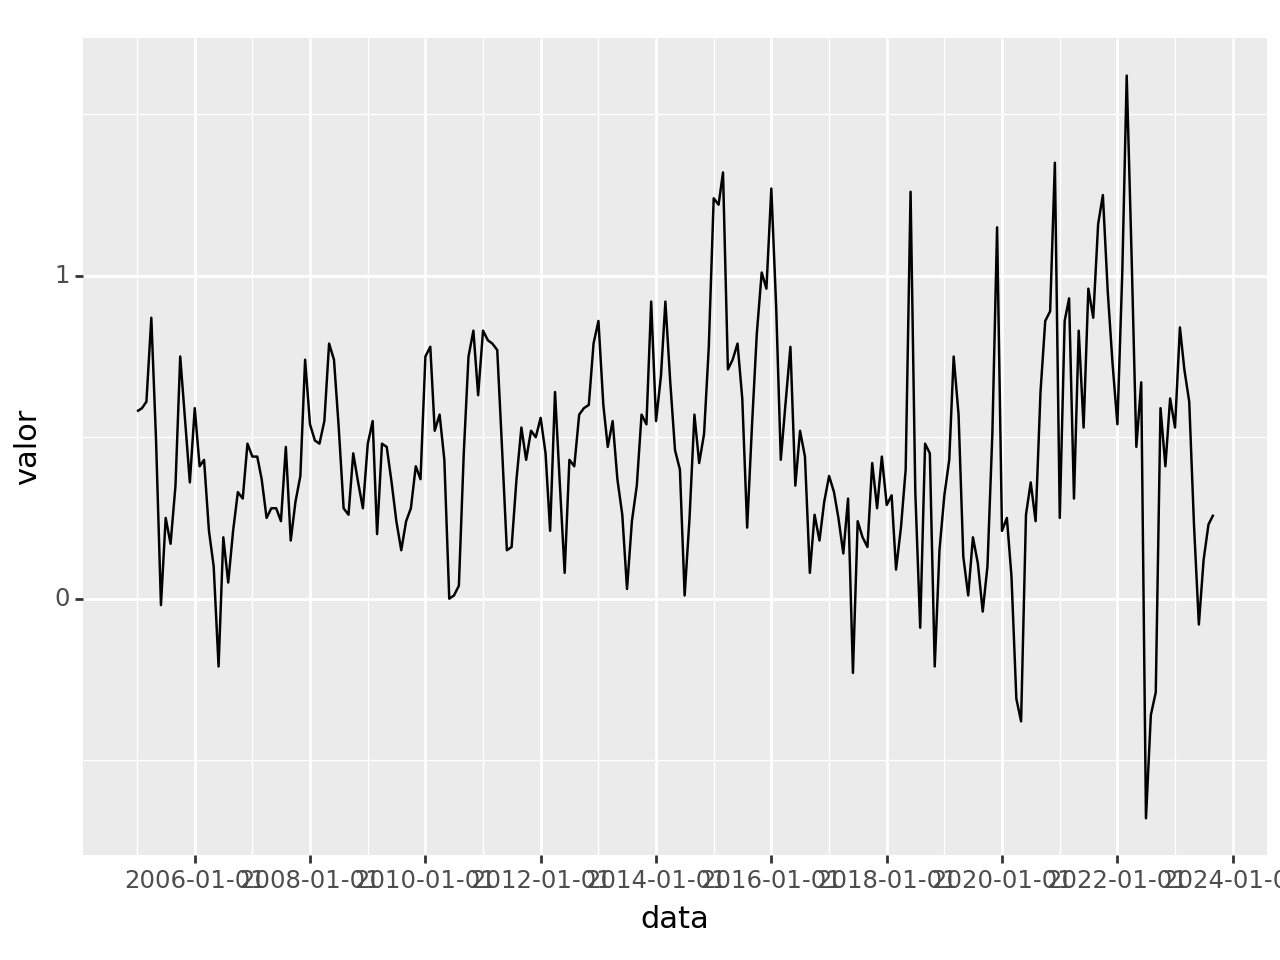

<Figure Size: (640 x 480)>

In [43]:
# Visualizar os dados
(
    p9.ggplot(tabela) +
    p9.aes(x = "data", y = "valor") +
    p9.geom_line()
)

In [40]:
# Especificar e estimar modelo
tabela_treino = tabela.query("data <= '2022-09-01'")
modelo = auto_arima(y = tabela_treino.valor, m = 12, seasonal = True)
print(modelo.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  213
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 -23.425
Date:                              Wed, 08 Nov 2023   AIC                             54.850
Time:                                      13:51:32   BIC                             68.295
Sample:                                           0   HQIC                            60.284
                                              - 213                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1841      0.037      4.918      0.000       0.111       0.257
ar.L1          0.59

In [93]:
# Previsão com o modelo
data_maxima = tabela_treino.data.max()
tabela_teste = tabela.query("data > @data_maxima")
tabela_teste

previsao = modelo.predict(12)
previsao

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


213    0.053106
214    0.216081
215    0.301876
216    0.364172
217    0.455140
218    0.554120
219    0.508692
220    0.436759
221    0.472611
222    0.302563
223    0.345128
224    0.351277
dtype: float64

In [94]:
previsao = pd.Series(previsao).reset_index()[0]
atual = tabela_teste.reset_index()["valor"]

In [97]:
# Avaliar o modelo
resultados = pd.DataFrame({"previsao": previsao, "atual": atual})

In [98]:
np.sqrt(mean_squared_error(resultados.atual, resultados.previsao))

0.2944321714305536